# Neural Network Forecaster

### Get the data from the historian

In [3]:
from bospy import bos

In [5]:
fcu_pts = bos.QueryPoints(parent_types="brick:Fan_Coil_Unit")
print(fcu_pts)

['bos://localhost/dev/12/pts/1', 'bos://localhost/dev/12/pts/10', 'bos://localhost/dev/12/pts/11', 'bos://localhost/dev/12/pts/12', 'bos://localhost/dev/12/pts/13', 'bos://localhost/dev/12/pts/14', 'bos://localhost/dev/12/pts/15', 'bos://localhost/dev/12/pts/16', 'bos://localhost/dev/12/pts/2', 'bos://localhost/dev/12/pts/3', 'bos://localhost/dev/12/pts/4', 'bos://localhost/dev/12/pts/5', 'bos://localhost/dev/12/pts/6', 'bos://localhost/dev/12/pts/7', 'bos://localhost/dev/12/pts/8', 'bos://localhost/dev/12/pts/9']


In [8]:
oa = 'bos://localhost/dev/12/pts/5'
sa = 'bos://localhost/dev/12/pts/4'
za = 'bos://localhost/dev/12/pts/1'
stpt = 'bos://localhost/dev/12/pts/3'
solar = 'bos://localhost/dev/12/pts/10'
fan = 'bos://localhost/dev/12/pts/6'

In [10]:
pts = [oa, sa, za, stpt, solar, fan]
df = bos.GetHistory(pts,
               start='2025/1/1T00:00:00-06',
               end='2025/1/30T24:00:00-06',
               pandas=True, tz='America/Denver', get_names=True).reset_index()
df.head(1)

,time,zone_temp,solar_irradiance,zone_htg_stpt,sa_temp_stpt,oa_temp,air_flow
0,2025-01-05 23:00:00-07:00,290.036865,0.0,288.149994,294.149994,269.850006,0.0


In [44]:
def PreprocessData(df:pd.DataFrame):
    import pandas as pd
    import numpy as np
    
    # predictions for the next time step, t+1
    y = df['zone_temp'].iloc[1:].copy()
    y = y.to_numpy()
    
    # feature vector for the current time, t
    X = df.iloc[:-1].copy()
    X['timestamp'] = pd.to_datetime(X['time'])
    
    # Extract time features
    X['day_of_week'] = X['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
    X['hour_of_day'] = X['timestamp'].dt.hour       # 0-23
    X['minute_of_day'] = X['timestamp'].dt.hour * 60 + X['timestamp'].dt.minute
    X = X.drop('time', axis=1)
    X = X.drop('timestamp', axis=1)
    X = X.astype(np.float32)
    X = X.to_numpy()

    return X, y

X, y = PreprocessData(df)
print(f'output shape:   {y.shape}')
print(f'features shape: {X.shape}')

output shape:   (2585,)
features shape: (2585, 9)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

In [19]:
# Assuming your data is in arrays X (features) and y (targets)
# X shape: (n_samples, 6), y shape: (n_samples,)

# Standardize features (important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [20]:
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [21]:
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)

In [22]:
# Create train/test split
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

In [23]:
# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### Define the network

In [27]:
class TemperatureMLP(nn.Module):
    def __init__(self, input_size=6, hidden_size=64):
        super(TemperatureMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model
model = TemperatureMLP(input_size=X.shape[1])

In [39]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X).squeeze()
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')

Epoch 0, Loss: 0.0116
Epoch 20, Loss: 0.0119
Epoch 40, Loss: 0.0099
Epoch 60, Loss: 0.0092
Epoch 80, Loss: 0.0082
Epoch 100, Loss: 0.0074
Epoch 120, Loss: 0.0066
Epoch 140, Loss: 0.0062
Epoch 160, Loss: 0.0050
Epoch 180, Loss: 0.0044
Epoch 200, Loss: 0.0039
Epoch 220, Loss: 0.0034
Epoch 240, Loss: 0.0027
Epoch 260, Loss: 0.0030
Epoch 280, Loss: 0.0025
Epoch 300, Loss: 0.0027
Epoch 320, Loss: 0.0020
Epoch 340, Loss: 0.0029
Epoch 360, Loss: 0.0021
Epoch 380, Loss: 0.0023
Epoch 400, Loss: 0.0019
Epoch 420, Loss: 0.0014
Epoch 440, Loss: 0.0016
Epoch 460, Loss: 0.0015
Epoch 480, Loss: 0.0015


In [40]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).squeeze()
    test_loss = criterion(test_predictions, y_test)
    
    # Convert back to original scale
    test_pred_original = scaler_y.inverse_transform(
        test_predictions.numpy().reshape(-1, 1)
    ).flatten()
    test_true_original = scaler_y.inverse_transform(
        y_test.numpy().reshape(-1, 1)
    ).flatten()
    
    # Calculate metrics
    mse = np.mean((test_pred_original - test_true_original)**2)
    rmse = np.sqrt(mse)
    print(f'Test RMSE: {rmse:.4f}°C')

Test RMSE: 0.3923°C


In [41]:
test_predictions.shape

torch.Size([517])

### Use trained model to predict temp at $t+1$

In [42]:
# scale and predict
normalized_input = scaler_X.transform(X)
new_tensor = torch.FloatTensor(normalized_input)

model.eval()
with torch.no_grad():
    predications_normalized = model(new_tensor)
    predictions = scaler_y.inverse_transform(predications_normalized.numpy())

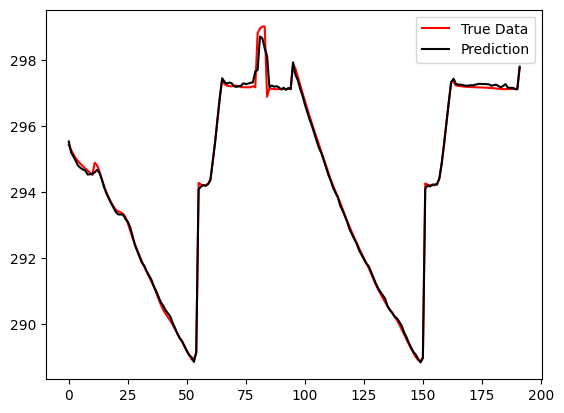

In [43]:
import matplotlib.pyplot as plt

steps_per_day = 96
start, end = steps_per_day * 2, steps_per_day * 4
sample_nums = [x for x in range(y[start:end].shape[0])]

plt.plot(sample_nums, y[start:end], color='red', label='True Data')
plt.plot(sample_nums, predictions[start:end], color='black', label='Prediction')
plt.legend()
plt.show()
# plt.plot(Y)

#### Unseen Data

In [107]:
new_df = bos.GetHistory(pts,
               start='2026/1/1T00:00:00-06',
               end='2026/1/28T24:00:00-06',
               pandas=True, tz='America/Denver', get_names=True).reset_index()
print(new_df.shape)
new_df.head()

(2400, 7)


,time,zone_temp,solar_irradiance,zone_htg_stpt,sa_temp_stpt,oa_temp,air_flow
0,2026-01-03 23:15:00-07:00,288.144226,0.0,288.149994,300.276306,249.574997,0.177320
1,2026-01-03 23:30:00-07:00,288.145203,0.0,288.149994,300.350067,249.300003,0.179459
2,2026-01-03 23:45:00-07:00,288.145203,0.0,288.149994,300.418243,249.024994,0.181432
3,2026-01-04 00:00:00-07:00,288.145172,0.0,288.149994,300.486816,248.750000,0.183417
4,2026-01-04 00:15:00-07:00,288.146942,0.0,288.149994,300.542328,248.767181,0.185031


In [108]:
X, y = PreprocessData(new_df)

In [109]:
# scale and predict
normalized_input = scaler_X.transform(X)
new_tensor = torch.FloatTensor(normalized_input)

model.eval()
with torch.no_grad():
    predications_normalized = model(new_tensor)
    predictions = scaler_y.inverse_transform(predications_normalized.numpy())

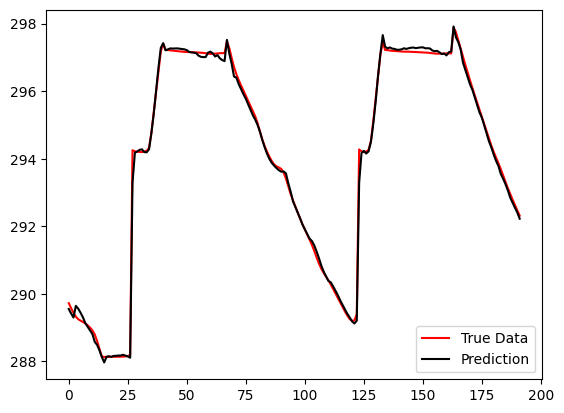

In [110]:
steps_per_day = 96
start, end = steps_per_day * 2, steps_per_day * 4
sample_nums = [x for x in range(y[start:end].shape[0])]

plt.plot(sample_nums, y[start:end], color='red', label='True Data')
plt.plot(sample_nums, predictions[start:end], color='black', label='Prediction')
plt.legend()
plt.show()

## Multi-step Prediction (Time Horizon)

In [117]:
new_df = bos.GetHistory(pts,
               start='2026/2/1T00:00:00-06',
               end='2026/2/2T24:00:00-06',
               pandas=True, tz='America/Denver', get_names=True).reset_index()
print(new_df.shape)
new_df.head()

(193, 7)


,time,zone_temp,solar_irradiance,zone_htg_stpt,sa_temp_stpt,oa_temp,air_flow
0,2026-01-31 23:00:00-07:00,288.846558,0.0,288.149994,294.149994,266.850006,0.0
1,2026-01-31 23:15:00-07:00,288.730804,0.0,288.149994,294.149994,267.141876,0.0
2,2026-01-31 23:30:00-07:00,288.609497,0.0,288.149994,294.149994,267.328339,0.0
3,2026-01-31 23:45:00-07:00,288.483307,0.0,288.149994,294.149994,267.450623,0.0
4,2026-02-01 00:00:00-07:00,288.354523,0.0,288.149994,294.149994,267.549988,0.0


<Axes: xlabel='time'>

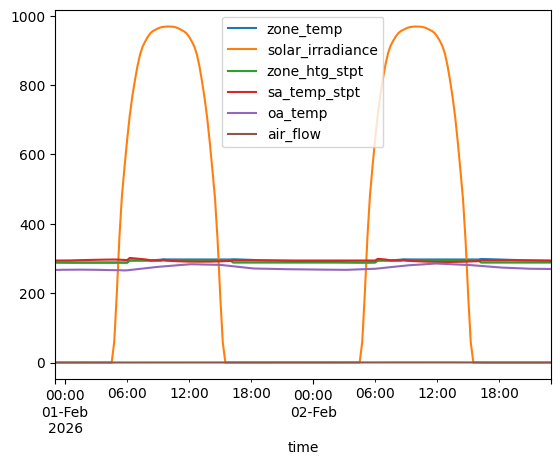

In [118]:
new_df.set_index('time').plot()

In [119]:
new_df = new_df[(new_df['time'] >= '2026-02-01T14:00:00') & (new_df['time'] <= '2026-02-01T18:00:00')]
new_df

,time,zone_temp,solar_irradiance,zone_htg_stpt,sa_temp_stpt,oa_temp,air_flow
60,2026-02-01 14:00:00-07:00,297.136230,633.189514,294.149994,290.958344,282.049988,0.283836
61,2026-02-01 14:15:00-07:00,297.131927,554.988281,294.149994,291.108032,281.976837,0.276990
62,2026-02-01 14:30:00-07:00,297.128296,473.000000,294.149994,291.291534,281.930817,0.268591
63,2026-02-01 14:45:00-07:00,297.122955,352.717896,294.149994,291.513794,281.794373,0.258425
64,2026-02-01 15:00:00-07:00,297.115356,195.277008,294.149994,291.801086,281.450012,0.245284
65,2026-02-01 15:15:00-07:00,297.110596,58.447628,294.149994,292.143555,280.819366,0.229603
66,2026-02-01 15:30:00-07:00,297.111511,0.000000,294.149994,292.497528,279.980804,0.213373
67,2026-02-01 15:45:00-07:00,297.115479,0.000000,294.149994,292.819397,279.051849,0.198607
68,2026-02-01 16:00:00-07:00,297.117065,0.000000,294.149994,293.120422,278.149994,0.184804
69,2026-02-01 16:15:00-07:00,297.778412,0.000000,288.149994,294.149994,277.300323,0.000000


<Axes: xlabel='time'>

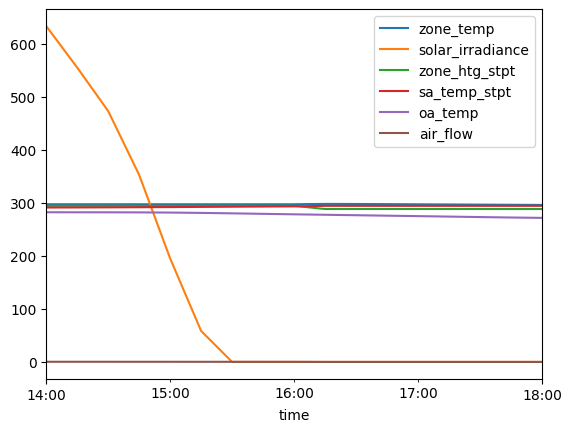

In [120]:
new_df.set_index('time').plot()

In [114]:
def predict_sequence(model, initial_features, n_steps, dt_minutes=15):
    """
    Predict a sequence of temperatures
    
    Args:
        initial_features: [current_temp, outdoor_temp, solar, occ, setpoint, time]
        n_steps: number of time steps to predict
        dt_minutes: time step size in minutes
    """
    predictions = []
    current_features = initial_features.copy()
    
    model.eval()
    with torch.no_grad():
        for step in range(n_steps):
            # Scale current features
            features_scaled = scaler_X.transform(current_features.reshape(1, -1))
            features_tensor = torch.FloatTensor(features_scaled)
            
            # Predict next temperature
            next_temp_scaled = model(features_tensor)
            next_temp = scaler_y.inverse_transform(
                next_temp_scaled.numpy().reshape(-1, 1)
            )[0, 0]
            
            predictions.append(next_temp)
            
            # Update features for next prediction
            # Use predicted temperature as new current temperature
            current_features[0] = next_temp
            
            # Update time feature (assuming it's in hours or similar)
            current_features[5] += dt_minutes / 60  # Convert to hours
            
            # You might also update other time-varying features like:
            # - outdoor temperature (if you have a forecast)
            # - solar gains
            # - occupancy schedule
            # - HVAC setpoint changes
    
    return np.array(predictions)

In [115]:
X, y = PreprocessData(new_df)

# Example usage
initial_state = np.array(X[0])
future_temps = predict_sequence(model, initial_state, n_steps=8)  # 6 hours ahead

print("Predicted temperature sequence:")
for i, temp in enumerate(future_temps):
    print(f"Step {i+1} (+{(i+1)*15} min): {temp:.2f}°C")

IndexError: index 0 is out of bounds for axis 0 with size 0

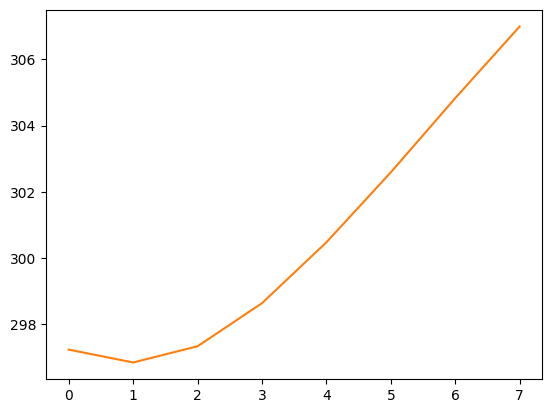

In [116]:
plt.plot(new_df['zone_temp'].iloc[:9].values)
plt.plot(future_temps)